In [8]:
import numpy as np
import os
import warnings
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import foamDataHandler as foam
import windLoadCaseProcessors as wProc
import windPlotters as wPlt
import windBasics as wind

# Inflow scaling

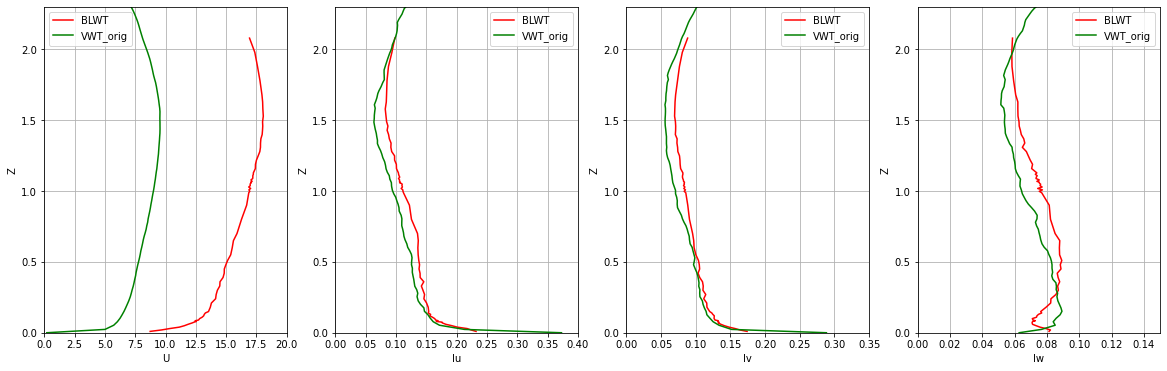

In [9]:
caseDir = "D:/tempData_depot/simData_CandC/tngE2/"
wtFile = caseDir+"tngE2Fr1_profile.csv"
vwtOrigFile = caseDir+"vwtO15orig.csv"

H = 0.08

target = wind.profile(name="BLWT",fileName=wtFile)#,Zref=H)
vwtOrig = wind.profile(name="VWT_orig",fileName=vwtOrigFile) #,Zref=H)

profs = wind.Profiles((target,vwtOrig))
profs.plotProfiles(
                    figSize=[20,6],
                    normalize=False,
                    xLimits=[[0,20],[0,0.4],[0,0.35],[0,0.15]],
                    zLimits=[0,2.3])



## Iteration 1

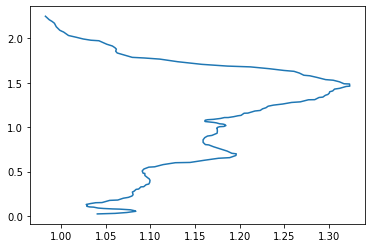

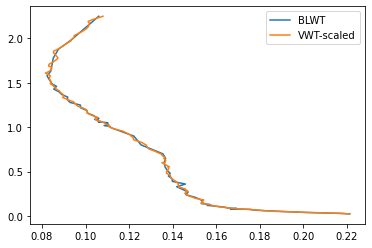

In [10]:
factorFile = caseDir+"tngE2_infScalingFactor_v0.csv"
Z = np.sort(np.concatenate((target.Z[2:],vwtOrig.Z[1:-10])))

intrp_U_wt = scintrp.interp1d(target.Z, target.U, fill_value='extrapolate')
intrp_Iu_wt = scintrp.interp1d(target.Z, target.Iu, fill_value='extrapolate')
intrp_Iv_wt = scintrp.interp1d(target.Z, target.Iv, fill_value='extrapolate')
intrp_Iw_wt = scintrp.interp1d(target.Z, target.Iw, fill_value='extrapolate')

intrp_U_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.U, fill_value='extrapolate')
intrp_Iu_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iu, fill_value='extrapolate')
intrp_Iv_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iv, fill_value='extrapolate')
intrp_Iw_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iw, fill_value='extrapolate')

fU = smooth(np.divide(intrp_U_wt(Z), intrp_U_vwt(Z)),15,3)
fIu = smooth(np.divide(intrp_Iu_wt(Z), intrp_Iu_vwt(Z)),15,3)
fIv = smooth(np.divide(intrp_Iv_wt(Z), intrp_Iv_vwt(Z)),15,3)
fIw = smooth(np.divide(intrp_Iw_wt(Z), intrp_Iw_vwt(Z)),15,3)

data = pd.DataFrame(np.stack((Z,fU,fIu,fIv,fIw),axis=-1),columns=["Z","U","Iu","Iv","Iw"])

# data.to_csv(factorFile,index=False)

plt.figure()
plt.plot(fIu,Z)

plt.figure()
plt.plot(intrp_Iu_wt(Z),Z,label="BLWT")
plt.plot(np.multiply(intrp_Iu_vwt(Z),fIu),Z,label="VWT-scaled")
plt.legend()

In [11]:
bData = "boundaryData_v1.0"
tRanges = ( ("0.0","5.0"),
            ("10.0","15.0"),
            ("30.0","35.0"),
            ("65.0","70.0"))
U = None
for t in tRanges:
    fileU = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_U-TH.npy"
    fileV = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_V-TH.npy"
    fileW = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_W-TH.npy"
    if U is None:
        U = np.load(fileU)
        V = np.load(fileV)
        W = np.load(fileW)
    else:
        U = np.concatenate((U,np.load(fileU)),axis=1)
        V = np.concatenate((V,np.load(fileV)),axis=1)
        W = np.concatenate((W,np.load(fileW)),axis=1)

print(np.shape(U))



(100, 8956)


In [12]:
file = caseDir+"constant/"+bData+"/Scaled_"+tRanges[0][0]+"_to_"+tRanges[0][1]+"_profiles.csv"
prfl = pd.read_csv(file)
scaled_v1_0 = wind.profile(name="scaled-v1.0", Z=prfl.Z,UofT=U,VofT=V,WofT=W,Zref=H)

profs = wind.Profiles((target,vwtOrig,scaled_v1_0))


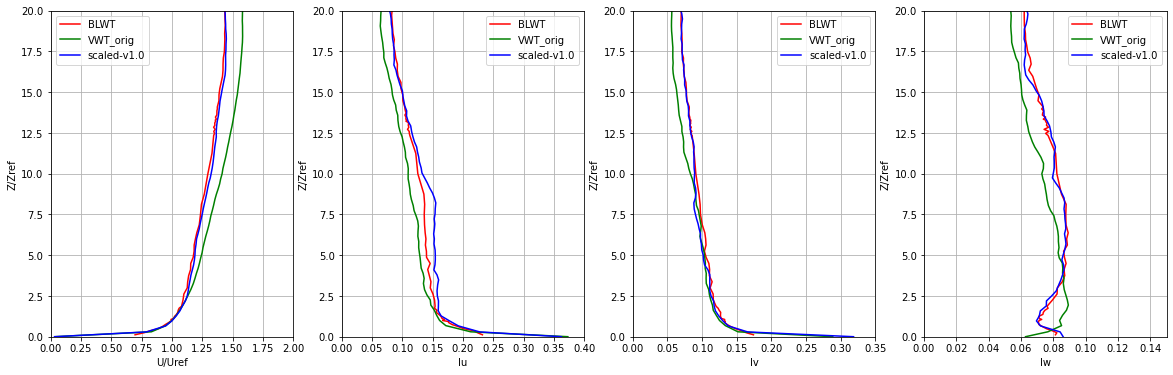

In [16]:

profs.plotProfiles(
                    figSize=[20,6],
                    normalize=True,
                    xLimits=[[0,2],[0,0.4],[0,0.35],[0,0.15]],
                    zLimits=[0,20])

In [14]:

print((None, None, 4, 3).count(None))

2
